In [18]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
 94% 737M/788M [00:04<00:00, 167MB/s]
100% 788M/788M [00:05<00:00, 144MB/s]


In [13]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,BatchNormalization,Dropout

In [4]:
import os
from PIL import Image

data_dir = "/content/PetImages"

for class_name in ["Cat", "Dog"]:
    class_dir = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_dir):
        fpath = os.path.join(class_dir, fname)
        try:
            img = Image.open(fpath)
            img.verify()
        except:
            if os.path.exists(fpath):
                os.remove(fpath)

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [5]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/PetImages',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,    # 80% train
    subset='training',
    seed=123
)

val_ds = keras.utils.image_dataset_from_directory(
    directory='/content/PetImages',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset='validation',
    seed=123
)

Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Found 24998 files belonging to 2 classes.
Using 4999 files for validation.


In [6]:
train_ds = train_ds.ignore_errors()
val_ds = val_ds.ignore_errors()

In [7]:
# Normalize
def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

  train_ds = train_ds.map(process)
  val_ds = val_ds.map(process)

In [14]:
# Create CNN Model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
history = model.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10
    618/Unknown 58s 84ms/step - accuracy: 0.5620 - loss: 2.2539

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


618/618 ━━━━━━━━━━━━━━━━━━━━ 66s 97ms/step - accuracy: 0.5620 - loss: 2.2521 - val_accuracy: 0.6593 - val_loss: 0.6217
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 54s 88ms/step - accuracy: 0.6117 - loss: 0.6297 - val_accuracy: 0.6047 - val_loss: 0.5731
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.6839 - loss: 0.5537 - val_accuracy: 0.6607 - val_loss: 0.5633
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 54s 88ms/step - accuracy: 0.7327 - loss: 0.4921 - val_accuracy: 0.7786 - val_loss: 0.4912
Epoch 5/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.7768 - loss: 0.4211 - val_accuracy: 0.7704 - val_loss: 0.4924
Epoch 6/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8082 - loss: 0.3777 - val_accuracy: 0.7610 - val_loss: 0.5329
Epoch 7/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.8217 - loss: 0.3341 - val_accuracy: 0.7548 - val_loss: 0.5805
Epoch 8/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8477 - loss: 0.2833 - val_accurac

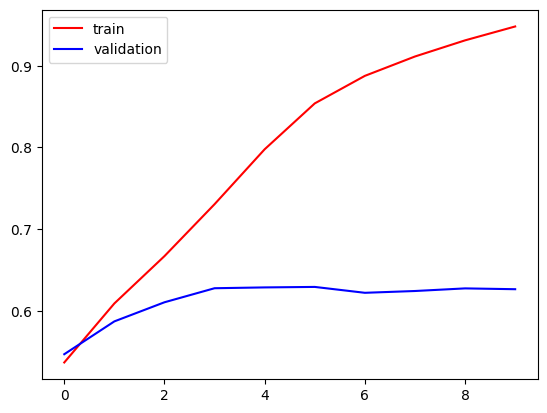

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

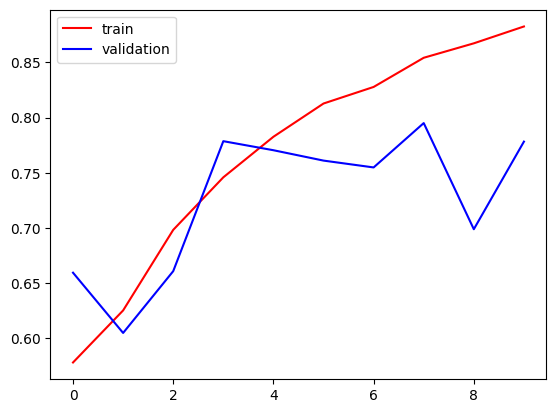

In [19]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

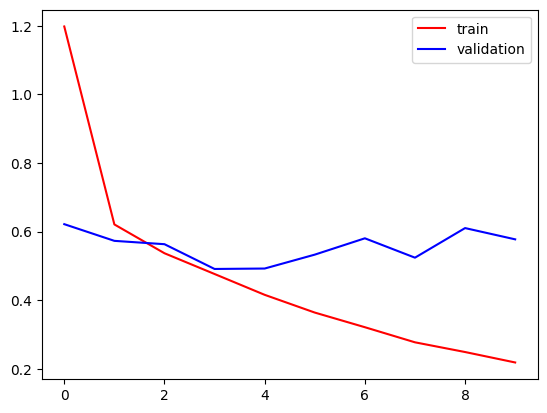

In [20]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [21]:
import cv2

In [24]:
test_img = cv2.imread('/content/dog.jpg')

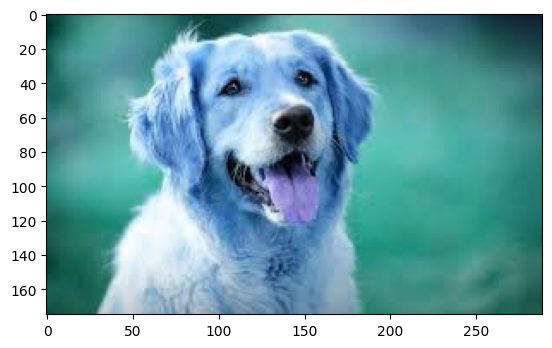

In [25]:
plt.imshow(test_img)

In [26]:
test_img.shape

(175, 289, 3)

In [27]:
test_img = cv2.resize(test_img,(256,256))

In [28]:
test_input = test_img.reshape((1,256,256,3))

In [29]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.9865017]], dtype=float32)

In [36]:
test_img = cv2.imread('/content/cat.jpg')

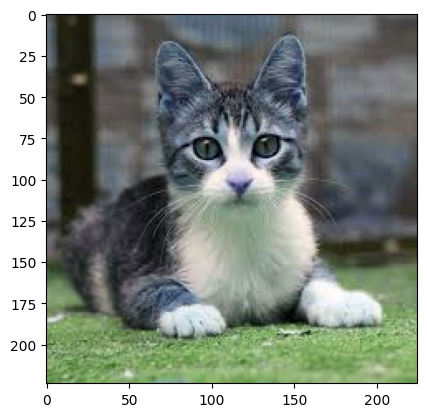

In [37]:
plt.imshow(test_img)

In [38]:
test_img.shape

(224, 225, 3)

In [39]:
test_img = cv2.resize(test_img,(256,256))

In [40]:
test_input = test_img.reshape((1,256,256,3))

In [41]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[0.00153378]], dtype=float32)